In [1]:
# required for jupyter notebook
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)}) # set sns figure size

import os
import math

In [2]:
def show_corr_heatmap(df):
    # https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

    plt.figure(figsize=(20, 10))

    corr_matrix = df.corr()

    # mask to hide the upper triangle of the symmetric corr-matrix
    # mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

    heatmap = sns.heatmap(

        # correlation matrix
        corr_matrix,

        # mask the top triangle of the matrix
        # mask=mask,

        # two-contrast color, different color for + -
        cmap="PiYG",

        # color map range
        vmin=-1, vmax=1,

        # show corr values in the cells
        annot=True
    )

    # set a title
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=16);

    plt.show()

In [3]:
# read Gazipur raw csv by marking missing values as NaN
missing_values = ['NIL', 'nil', '']
gazipur_df = pd.read_csv(os.path.join('..', 'Datasets', 'brri-datasets', 'gazipur_2016-2020', 'gazipur.csv'), 
                     na_values=missing_values)

gazipur_df.head()

,Station,Year,Month,Day,Max Temp. (degree Celcius),Min Temp. (degree Celcius),Rainfall (mm),Actual Evaporation (mm),"Relative Humidity (morning, %)","Relative Humidity (afternoon, %)",Sunshine (hour/day),Cloudy (hour/day),Solar Radiation (cal/cm^2/day)
0,Barisal,2017,1,1,25.2,13.8,0.0,1.0,94,62.0,6.3,4.5,277.72
1,Barisal,2017,1,2,25.4,13.8,0.0,1.0,94,62.0,5.5,5.3,257.52
2,Barisal,2017,1,3,25.6,13.4,0.0,1.0,94,61.0,6.2,4.6,275.20
3,Barisal,2017,1,4,25.4,14.0,0.0,1.0,94,64.0,6.3,4.5,277.72
4,Barisal,2017,1,5,23.0,13.0,0.0,1.0,94,68.0,4.0,6.8,219.63


In [4]:
def get_avg_df(_df, num_avg_days=7, num_days_before=3):
    '''
    input STATION-WISE dataframe with all expected columns
    returns dataframe with rainfall columns unchanged 
        and average of 'num_avg_days' number of days worth other features 
        and starting from 'num_days_before' ago
        
    example: num_avg_days=7, num_days_before=3
        then row for January 10 will have rainfall data of Jan 10 
            and other columns will have average of values from Jan 1 to 7
    '''
    df=_df.copy()
    
    MONTH_COL = 'Month'
    MAX_TEMP_COL = 'Max Temp. (degree Celcius)'
    MIN_TEMP_COL = 'Min Temp. (degree Celcius)'
    RAINFALL_COL = 'Rainfall (mm)'
    ACTUAL_EVA_COL = 'Actual Evaporation (mm)'
    REL_HUMIDITY_M_COL = 'Relative Humidity (morning, %)'
    REL_HUMIDITY_A_COL = 'Relative Humidity (afternoon, %)'
    SUNSHINE_COL = 'Sunshine (hour/day)'
    CLOUDY_COL = 'Cloudy (hour/day)'
    SOLAR_RAD_COL = 'Solar Radiation (cal/cm^2/day)'

    months, min_temps, max_temps, rainfalls, actual_evas, rhs_m, rhs_a, sunshines, cloudies, solar_rads = \
    [], [], [], [], [], [], [], [], [], [] 

    def get_list_with_col(df, col_name):
        # returns list of columns from dataframe
        vals = []
        for val in df[col_name]:
            vals.append(val);
        return vals;

    # populate list with daily features
    months = get_list_with_col(df, MONTH_COL)
    min_temps = get_list_with_col(df, MIN_TEMP_COL)
    max_temps = get_list_with_col(df, MAX_TEMP_COL)
    rainfalls = get_list_with_col(df, RAINFALL_COL)
    actual_evas = get_list_with_col(df, ACTUAL_EVA_COL)
    rhs_m = get_list_with_col(df, REL_HUMIDITY_M_COL)
    rhs_a = get_list_with_col(df, REL_HUMIDITY_A_COL)
    sunshines = get_list_with_col(df, SUNSHINE_COL)
    cloudies = get_list_with_col(df, CLOUDY_COL)
    solar_rads = get_list_with_col(df, SOLAR_RAD_COL)

    def get_avg_in_range(vals, start, end):
        '''
        returns average of list values from start to end index 
        '''
        total = 0.0
        for i in range(start, end+1):
            total+=vals[i]
        return float(total/(end-start+1));

    new_months, new_min_temps, new_max_temps, new_rainfalls, new_actual_evas, \
    new_rhs_m, new_rhs_a, new_sunshines, new_cloudies, new_solar_rads = [], [], [], [], [], [], [], [], [], [] 

    output_rainfalls = []
    
    # populate new features with previous average values
    for curr_idx in range(num_avg_days+num_days_before, df.shape[0]):
        avg_start_idx = curr_idx-(num_avg_days+num_days_before)
        avg_end_idx = avg_start_idx+num_days_before-1
        
        new_min_temps.append(get_avg_in_range(min_temps, avg_start_idx, avg_end_idx))
        new_max_temps.append(get_avg_in_range(max_temps, avg_start_idx, avg_end_idx))
        new_actual_evas.append(get_avg_in_range(actual_evas, avg_start_idx, avg_end_idx))
        new_rhs_m.append(get_avg_in_range(rhs_m, avg_start_idx, avg_end_idx))
        new_rhs_a.append(get_avg_in_range(rhs_a, avg_start_idx, avg_end_idx))
        new_sunshines.append(get_avg_in_range(sunshines, avg_start_idx, avg_end_idx))
        new_cloudies.append(get_avg_in_range(cloudies, avg_start_idx, avg_end_idx))
        new_solar_rads.append(get_avg_in_range(solar_rads, avg_start_idx, avg_end_idx))
        new_rainfalls.append(get_avg_in_range(rainfalls, avg_start_idx, avg_end_idx))
        
        # in case days fall in two months, set the month that covers most days
        new_months.append(int(get_avg_in_range(months, avg_start_idx, avg_end_idx)))
        
        output_rainfalls.append(rainfalls[curr_idx])

    return pd.DataFrame({MONTH_COL: new_months,
                         'Avg '+ MIN_TEMP_COL: new_min_temps,
                         'Avg '+ MAX_TEMP_COL: new_max_temps,
                         'Avg '+ RAINFALL_COL: new_rainfalls,
                         'Avg '+ ACTUAL_EVA_COL: new_actual_evas, 
                         'Avg '+ REL_HUMIDITY_M_COL: new_rhs_m,
                         'Avg '+ REL_HUMIDITY_A_COL: new_rhs_a,
                         'Avg '+ SUNSHINE_COL: new_sunshines,
                         'Avg '+ CLOUDY_COL: new_cloudies,
                         'Avg '+ SOLAR_RAD_COL: new_solar_rads,
                         RAINFALL_COL: output_rainfalls
                        })

In [5]:
gazipur_avg_df = get_avg_df(gazipur_df)

In [6]:
gazipur_avg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443 entries, 0 to 1442
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Month                                 1443 non-null   int64  
 1   Avg Min Temp. (degree Celcius)        1437 non-null   float64
 2   Avg Max Temp. (degree Celcius)        1440 non-null   float64
 3   Avg Rainfall (mm)                     1285 non-null   float64
 4   Avg Actual Evaporation (mm)           1401 non-null   float64
 5   Avg Relative Humidity (morning, %)    1443 non-null   float64
 6   Avg Relative Humidity (afternoon, %)  1356 non-null   float64
 7   Avg Sunshine (hour/day)               1443 non-null   float64
 8   Avg Cloudy (hour/day)                 1443 non-null   float64
 9   Avg Solar Radiation (cal/cm^2/day)    1443 non-null   float64
 10  Rainfall (mm)                         1315 non-null   float64
dtypes: float64(10), i

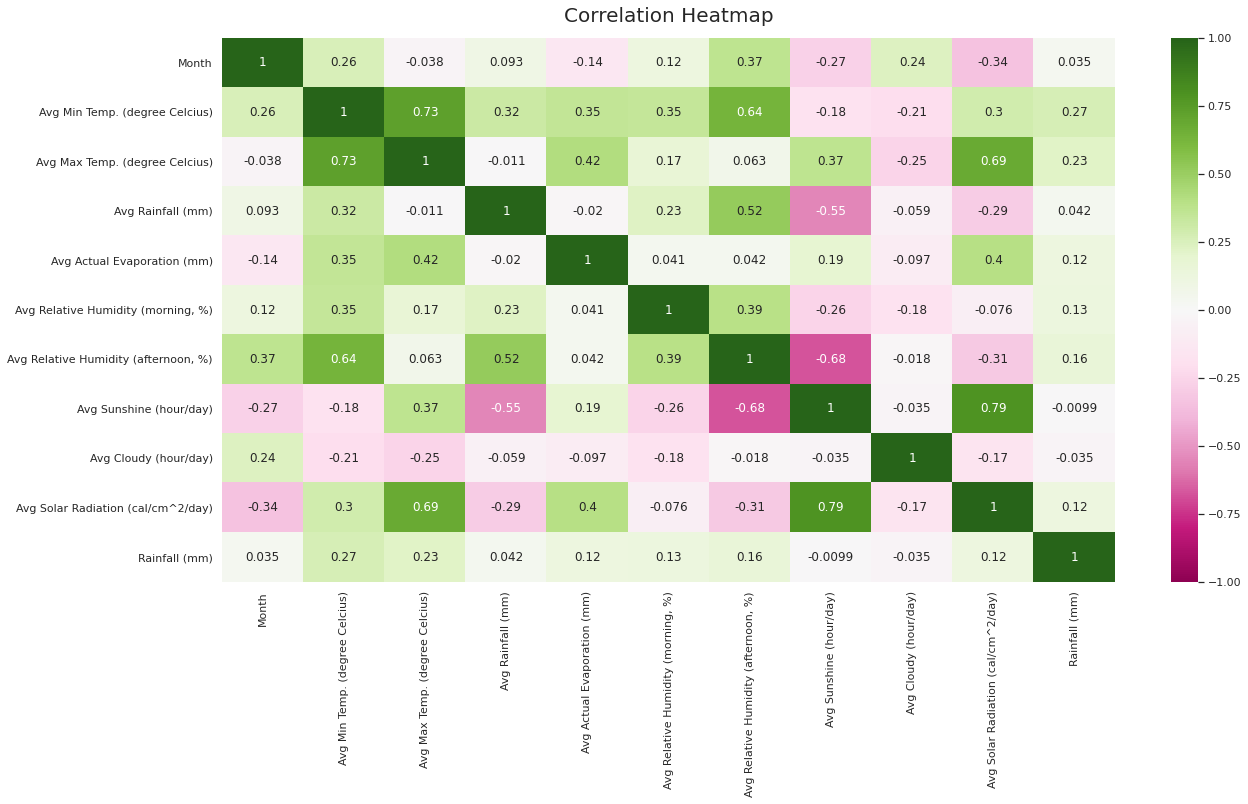

In [7]:
show_corr_heatmap(gazipur_avg_df)

In [8]:
def rain_classifier(_df):
    df = _df.copy()
    
    data = df['Rainfall (mm)']
    arr = []
    arr_enc = []
    for x in data:
        if x=='NIL':
            arr.append('NIL')
            arr_enc.append('NIL')
        else:
            if float(x)==0.0:
                arr.append('no rain')
                arr_enc.append(0)
            elif float(x)>0.0 and float(x)<=20.0:
                arr.append('mild rain')
                arr_enc.append(1)
            elif float(x)>20.0:
                arr.append('medium to heavy rain')
                arr_enc.append(2)
            else: 
                # add NaN values as is
                arr.append(x)
                arr_enc.append(x)
        
    df['Rainfall Type'] = arr
    df['Rainfall Type (encoded)'] = arr_enc

    return df

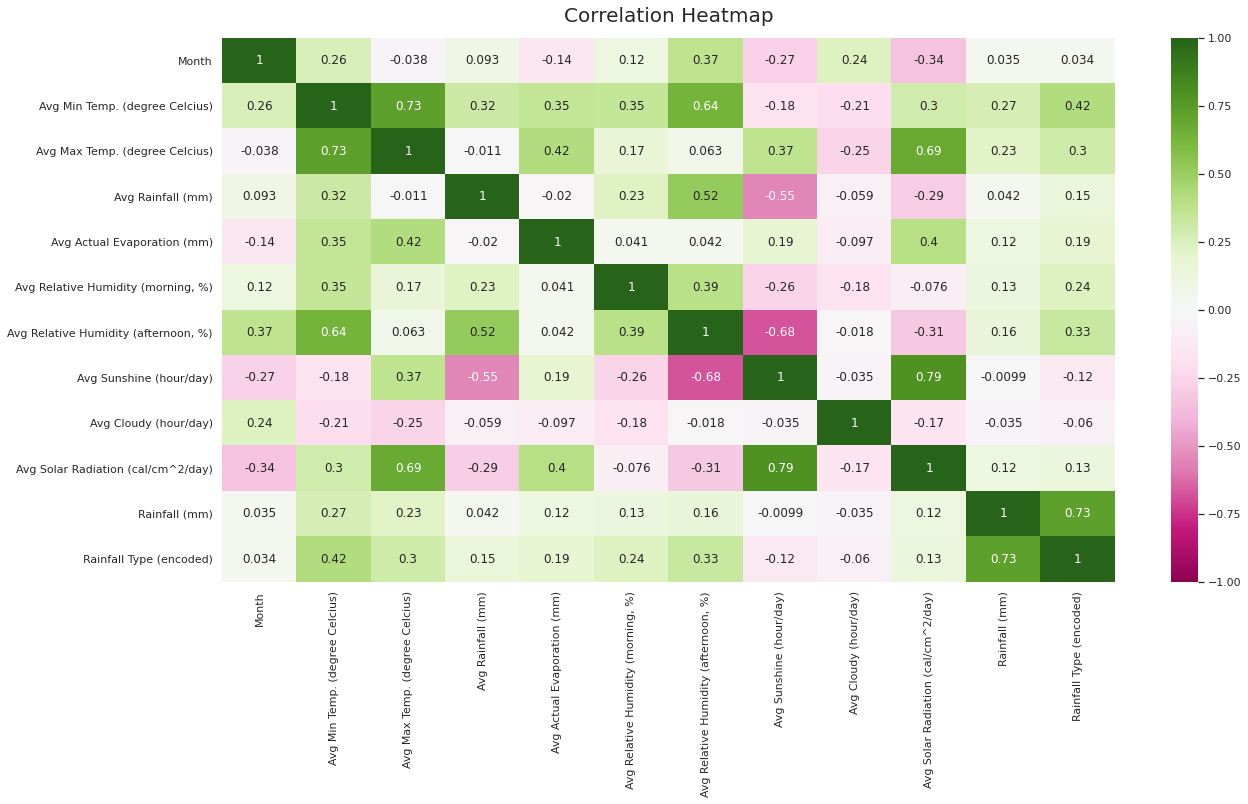

In [9]:
show_corr_heatmap(rain_classifier(gazipur_avg_df))